##### Packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import gelu
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation

c:\Users\vebky\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Data Processing

In [2]:
data = pd.read_csv("C:/Users/vebky/FIE458/termpaper/Cleaned_Data.csv")
data.head()

,Unnamed: 0,Project,Text,Scam,Text_Encoded_Word,Text_Encoded_Character
0,0,acs crypto,crims switch de-fi police trace crypto crimes ...,1,"[725437, 492541, 1102845, 437298, 885216, 6438...","[138, 161, 38, 90, 289, 0, 289, 7, 38, 282, 13..."
1,1,acs crypto,welcome aircentralstation join aircentralstati...,1,"[194583, 30197, 407032, 30197, 1413970, 109968...","[7, 155, 31, 138, 24, 90, 155, 0, 50, 38, 161,..."
2,2,adaf,this zesty faucet from @_bitcoiner making twee...,1,"[1310907, 843491, 224679, 1221500, 84711, 1099...","[282, 178, 38, 289, 0, 237, 155, 289, 282, 72,..."
3,3,adaf,@bondwolfie . all doctors are fatphobic world ...,1,"[0, 1044714, 1433243, 945028, 45136, 1021170, ...","[3, 230, 24, 6, 10, 7, 24, 31, 212, 38, 155, 0..."
4,4,adaf,@umezawa_ honestly idk. might make sense check...,1,"[571361, 454028, 878217, 1044714, 595598, 1148...","[3, 198, 90, 155, 237, 50, 7, 50, 53, 0, 178, ..."


#### Balanced Data

In [3]:
# Sample a subset of the data, 50000 rows, which is 50% scam=1 and 50% scam=0
bal = data.groupby('Scam').apply(lambda x: x.sample(25000, random_state=1)).reset_index(drop=True)
bal.head()

,Unnamed: 0,Project,Text,Scam,Text_Encoded_Word,Text_Encoded_Character
0,236830,hedera,auction klaxon! only six hours left these two ...,0,"[1164211, 695772, 781942, 437276, 94468, 63273...","[50, 198, 138, 282, 38, 24, 6, 0, 239, 31, 50,..."
1,218583,fantom,hyped for 2022 with this amazing hector team j...,0,"[1037456, 986965, 1270237, 526037, 1310907, 98...","[178, 72, 300, 155, 10, 0, 212, 24, 161, 0, 18..."
2,276366,mina,🤷🏾‍♂️🤷🏾‍♂️🤷🏾‍♂️ thank you !! @mithisa_motho yo...,0,"[652624, 672369, 652624, 672369, 652624, 67236...","[0, 0, 0, 0, 100, 0, 0, 0, 0, 100, 0, 0, 0, 0,..."
3,231603,gnosis,"@dihuaflute the , they might well while we're ...",0,"[0, 586665, 43212, 1048353, 595598, 791932, 37...","[3, 10, 38, 178, 198, 50, 212, 31, 198, 282, 1..."
4,364445,thorchain,@akurypto @ but #rune dead @akurypto @ that’s ...,0,"[1121754, 695055, 486027, 540467, 386209, 1121...","[3, 50, 239, 198, 161, 72, 300, 282, 24, 0, 3,..."


In [4]:
# number of unique entries in "Scam" column and the count of each
bal['Scam'].value_counts()

0    25000
1    25000
Name: Scam, dtype: int64

#### Unbalanced Data

In [5]:
# Sample a subset of the data, 50000 rows
unbal = data.apply(lambda x: x.sample(25000, random_state=1)).reset_index(drop=True)
unbal.head()

,Unnamed: 0,Project,Text,Scam,Text_Encoded_Word,Text_Encoded_Character
0,299782,pancakeswap,@terry265 @ @essentialesc @moonscan @coinlisti...,0,"[339491, 695055, 307718, 1018756, 1382421, 114...","[3, 282, 155, 161, 161, 72, 187, 295, 54, 0, 3..."
1,226913,flow,#nowplaying frank nitti/coco therapy morning ...,0,"[833118, 720732, 610204, 139641, 1042138, 1349...","[172, 6, 24, 7, 300, 31, 50, 72, 38, 6, 5, 0, ..."
2,313233,quant,swing ticker ticker.52 ticker ticker.29 ticker...,0,"[819299, 862855, 862855, 1044714, 106115, 8628...","[289, 7, 38, 6, 5, 0, 282, 38, 138, 239, 155, ..."
3,97290,thodex,"𝐁𝐓𝐂-𝐓𝐑𝐘 𝐄𝐗𝐂𝐇𝐀𝐍𝐆𝐄 𝐑𝐀𝐓𝐄𝐒: btcturk: 47,747.00 try...",1,"[294790, 258985, 821046, 275066, 173398, 27506...","[0, 0, 0, 247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,332405,stacks,never play duos. find too easy you only have d...,0,"[1076143, 859171, 1390548, 1044714, 1202051, 9...","[6, 155, 266, 155, 161, 0, 300, 31, 50, 72, 0,..."


In [6]:
unbal['Scam'].value_counts()

0    18821
1     6179
Name: Scam, dtype: int64

## Dictionaries

#### Sourcing Text

In [7]:
# Change dataframe if you want balanced/unbalanced data
text = bal['Text'].values
vocabSize = 5000

#### Bag of Words: Words

In [8]:
BagOfWords = CountVectorizer(max_features=vocabSize, stop_words='english')
BOW = BagOfWords.fit_transform(text)

#### Bag of Words: Ngrams

In [9]:
CharNgrams = CountVectorizer(analyzer='char', ngram_range=(1, 3), max_features=vocabSize)
CHAR = CharNgrams.fit_transform(text)

#### Bag of Words: TF-IDF

In [10]:
TF_IDF = TfidfVectorizer(analyzer='char', ngram_range=(1, 3), max_features=vocabSize)
tfIDF = TF_IDF.fit_transform(text)

#### Selecting the Dictionary

In [13]:
# create function to select dictionary type
def selectDict(name):
    DictList = {'BOW': BOW, 'CHAR': CHAR, 'tfIDF': tfIDF}
    if name in DictList:
        X = DictList[name]
        return X
    else:
        print('Invalid dictionary name')

Once this section is complete, there is no need to rerun it, unless changes to the data is made.

#### Creating Test Sets

In [14]:
# selecting X and Y (change dataframe as you did above)
X = selectDict('CHAR') # List: BOW, CHAR, tfIDF, LDABOC
Y = bal['Scam'].values

In [15]:
# creating randomly selected balanced training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

In [16]:
# dimensions of training and validation sets
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(40000, 5000)
(10000, 5000)
(40000,)
(10000,)


In [17]:
# Convert the sparse matrices to dense arrays
X_train_dense = X_train.toarray()
X_val_dense = X_val.toarray()

# Reshape the input data to have an additional dimension (channels)
X_train_reshaped = np.expand_dims(X_train_dense, axis=-1)
X_val_reshaped = np.expand_dims(X_val_dense, axis=-1)

Callback functions to gather batch-based statistics.

In [18]:
# Callback to log variation of loss within each epoch
class BatchLossCallback(Callback):
    def __init__(self):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

# Callback to log variation of accuracy within each epoch
class BatchAccuracyCallback(Callback):
    def __init__(self):
        self.batch_accuracies = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_accuracies.append(logs.get('accuracy'))


## CNN Model

### Iteration 3

##### Model Architecture

In [28]:
# Functional API
# Input layer
inputLayer = layers.Input(shape=(X_train_reshaped.shape[1], 1))

#Convolutional layer
conv1 = layers.Conv1D(128, 3, activation=gelu, padding='same')(inputLayer)
conv2 = layers.Conv1D(128, 7, activation=gelu, padding='same')(inputLayer)
max_pool1 = layers.MaxPooling1D()(conv1)
max_pool2 = layers.MaxPooling1D()(conv2)

#MaxPooling layer
concat = layers.Concatenate()([max_pool1, max_pool2])
drop1 = layers.Dropout(0.01)(concat)

#Dense Layer
flatten = layers.Flatten()(concat)
dense = layers.Dense(128, activation=gelu)(flatten)
drop2 = layers.Dropout(0.01)(dense)
bnorm1 = layers.BatchNormalization()(drop2)
dense2 = layers.Dense(32, activation=gelu)(bnorm1)
bnorm2 = layers.BatchNormalization()(dense2)
dense3 = layers.Dense(16, activation=gelu)(bnorm2)
drop3 = layers.Dropout(0.01)(dense3)

#Output
output = layers.Dense(1, activation="sigmoid")(drop3)

# Create the model
model = Model(inputs=inputLayer, outputs=output)

In [29]:
# Optimiser
optimizer = optimizer = tfa.optimizers.RectifiedAdam(learning_rate=0.001, weight_decay=0.01)


# Callbacks
batch_loss_callback = BatchLossCallback()
batch_accuracy_callback = BatchAccuracyCallback()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=1, mode='max', restore_best_weights=True)

# Create a list of callbacks
callbacks_list = [early_stopping, batch_loss_callback, batch_accuracy_callback]

In [30]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

##### Performance, Metrics, Plots

History

In [31]:
# Train the model
history = model.fit(X_train_reshaped, Y_train, epochs=100, validation_data=(X_val_reshaped, Y_val), batch_size=40, callbacks=callbacks_list)

Epoch 1/100
1000/1000 [==============================] - 1970s 2s/step - loss: 0.3669 - accuracy: 0.8259 - val_loss: 0.3375 - val_accuracy: 0.8448
Epoch 2/100
1000/1000 [==============================] - 1945s 2s/step - loss: 0.2633 - accuracy: 0.8834 - val_loss: 0.2847 - val_accuracy: 0.8728
Epoch 3/100
1000/1000 [==============================] - 1904s 2s/step - loss: 0.2092 - accuracy: 0.9104 - val_loss: 0.3028 - val_accuracy: 0.8832
Epoch 4/100
1000/1000 [==============================] - 1900s 2s/step - loss: 0.1671 - accuracy: 0.9298 - val_loss: 0.2594 - val_accuracy: 0.8841
Epoch 5/100
1000/1000 [==============================] - 1920s 2s/step - loss: 0.1380 - accuracy: 0.9421 - val_loss: 0.3063 - val_accuracy: 0.8714
Epoch 5: early stopping


Performance Plot

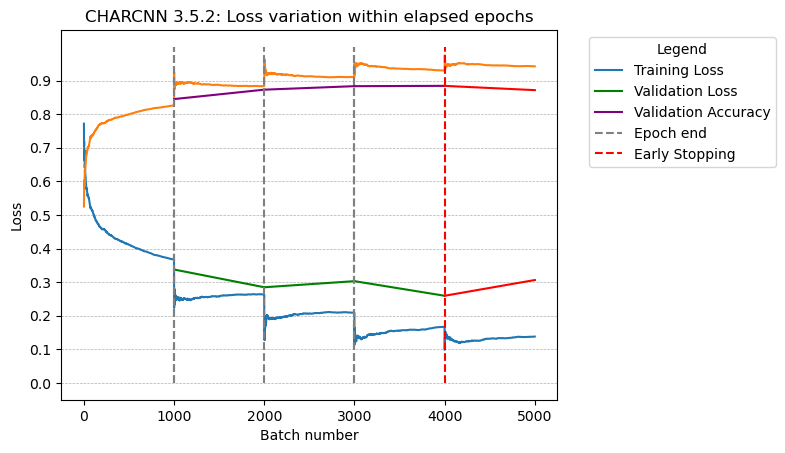

In [44]:
# Plot the batch-wise loss variation within the epoch
plt.plot(np.arange(len(batch_loss_callback.batch_losses)), batch_loss_callback.batch_losses, label='Training Loss')
# Plot the batch-wise accuracy variation within the epochs
plt.plot(np.arange(len(batch_accuracy_callback.batch_accuracies)), batch_accuracy_callback.batch_accuracies)

# draw line sbetween the points
plt.plot([1000, 2000], [history.history['val_loss'][0], history.history['val_loss'][1]], color='green', label='Validation Loss')
plt.plot([2000, 3000], [history.history['val_loss'][1], history.history['val_loss'][2]], color='green')
plt.plot([3000, 4000], [history.history['val_loss'][2], history.history['val_loss'][3]], color='green')
plt.plot([4000, 5000], [history.history['val_loss'][3], history.history['val_loss'][4]], color='red')
plt.plot([1000, 2000], [history.history['val_accuracy'][0], history.history['val_accuracy'][1]], color='purple', label='Validation Accuracy')
plt.plot([2000, 3000], [history.history['val_accuracy'][1], history.history['val_accuracy'][2]], color='purple')
plt.plot([3000, 4000], [history.history['val_accuracy'][2], history.history['val_accuracy'][3]], color='purple')
plt.plot([4000, 5000], [history.history['val_accuracy'][3], history.history['val_accuracy'][4]], color='red')

# Lines
plt.yticks(np.arange(0, 1, 0.1))
plt.vlines(1000, 0, 1, colors='gray', linestyles='dashed', label='Epoch end')
plt.vlines(1000, 0, 1, colors='gray', linestyles='dashed')
plt.vlines(2000, 0, 1, colors='gray', linestyles='dashed')
plt.vlines(3000, 0, 1, colors='gray', linestyles='dashed')
plt.vlines(4000, 0, 1, colors='red', linestyles='dashed', label = 'Early Stopping')
plt.vlines(3000, 0, 1, colors='gray', linestyles='dashed')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.title(f'CHARCNN 3.5.2: Loss variation within elapsed epochs')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')

plt.show()

Evaluation

In [33]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val_reshaped, Y_val)
print(f"Validation loss: {loss}, accuracy: {accuracy}")

313/313 [==============================] - 81s 252ms/step - loss: 0.2594 - accuracy: 0.8841
Validation loss: 0.2594147324562073, accuracy: 0.8841000199317932


Confusion Matrix

In [34]:
# Convert the sparse input data to dense format
X_val_dense = X_val.todense()

# Get the model's predictions on the dense validation set
y_pred = model.predict(X_val_dense)

313/313 [==============================] - 74s 235ms/step


In [35]:
y_pred_classes = np.round(y_pred).astype(int)  # For binary classification

[[4328  672]
 [ 487 4513]]


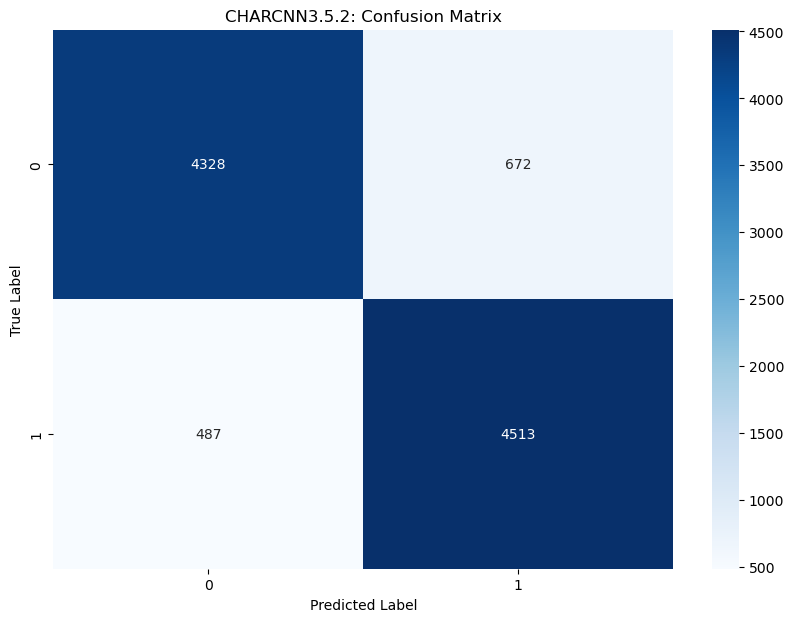

In [45]:
# Compute the confusion matrix
cm = confusion_matrix(Y_val, y_pred_classes)
print(cm)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CHARCNN3.5.2: Confusion Matrix')
plt.show()

### BOWCNN2: Functional Convolutional Layers, Adam Optimizer

Input layer

    inputLayer = layers.Input(shape=(X_train_reshaped.shape[1], 1))

Convolutional layer

    conv1 = layers.Conv1D(128, 5, activation=gelu)(inputLayer)

    drop1 = layers.Dropout(0.01)(conv1)

MaxPooling layer

    max_pool = layers.MaxPooling1D()(drop1)

Dense Layer

    flatten = layers.Flatten()(max_pool)

    dense = layers.Dense(128, activation=gelu)(flatten)
    
    dense2 = layers.Dense(32, activation=gelu)(dense)

Output
    output = layers.Dense(1, activation="sigmoid")(dense2)

Create the model

    model = Model(inputs=inputLayer, outputs=output)

Compile the model

    optimizer = Adam(learning_rate=0.001)

    early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='min', restore_best_weights=True)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### BOWCNN3: Functional Convolutional Layers, Rectified Adam Optimizer


Input layer

    inputLayer = layers.Input(shape=(X_train_reshaped.shape[1], 1))

Convolutional layer

    conv1 = layers.Conv1D(128, 3, activation=gelu)(inputLayer)
    drop1 = layers.Dropout(0.01)(conv1)

MaxPooling layer

    max_pool = layers.MaxPooling1D()(drop1)

Dense Layer

    flatten = layers.Flatten()(max_pool)
    dense = layers.Dense(128, activation=gelu)(flatten)
    dense2 = layers.Dense(32, activation=gelu)(dense)

Output

    output = layers.Dense(1, activation="sigmoid")(dense2)

Create the model

    model = Model(inputs=inputLayer, outputs=output)

Optimiser

    optimizer = optimizer = tfa.optimizers.RectifiedAdam(learning_rate=0.001, weight_decay=0.01)

Callbacks

    batch_loss_callback = BatchLossCallback()

    batch_accuracy_callback = BatchAccuracyCallback()

    early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='min', restore_best_weights=True)

Create a list of callbacks

    callbacks_list = [early_stopping, batch_loss_callback, batch_accuracy_callback]

Compile the model

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])